<strong>Aluno</strong>: Victor São Paulo Ruela



In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.datasets import load_iris, load_breast_cancer

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from IPython.display import clear_output
import random


In [3]:
class RBF(BaseEstimator):
    def __init__(self, p, center_estimation='kmeans'):
        self.p = p
        self.center_estimation = center_estimation

    def apply_transformation(self, X):
        check_is_fitted(self, ['cov_', 'centers_'])
        N, n = X.shape
        H = np.zeros((N, self.p))
        for j in range(N):
            for i in range(self.p):
                mi = self.centers_[i, :]
                covi = self.cov_[i] + 0.001 * np.eye(n)
                H[j, i] = self.gaussian_kernel(X[j, :], mi, covi, n)
        return H

    def predict(self, X):
        # check X, y consistency
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, ['cov_', 'centers_', 'H_', 'coef_'])
        N, _ = X.shape

        H = self.apply_transformation(X)
        H_aug = np.hstack((np.ones((N, 1)), H))
        yhat = H_aug @ self.coef_

        return yhat

    def gaussian_kernel(self, X, m, K, n):
        if n == 1:
            r = np.sqrt(float(K))
            px = (1/(np.sqrt(2*np.pi*r*r)))*np.exp(-0.5 * (float(X-m)/r)**2)
            return px
        else:
            center_distance = (X - m).reshape(-1, 1)
            normalization_factor = np.sqrt(((2*np.pi)**n)*sp.linalg.det(K))
            dist = float(
                np.exp(-0.5 * (center_distance.T @ (sp.linalg.inv(K)) @ center_distance)))
            return dist / normalization_factor
            
    def make_centers(self, X):
        N, n = X.shape

        if(self.center_estimation == 'kmeans'):
            kmeans = KMeans(n_clusters=self.p).fit(X)
            self.centers_ = kmeans.cluster_centers_
            # estimate covariance matrix for all centers
            clusters = kmeans.predict(X)
            covlist = []
            for i in range(self.p):
                xci = X[clusters == i, :]
                covi = np.cov(xci, rowvar=False) if n > 1 else np.asarray(
                    np.var(xci))
                covlist.append(covi)
            self.cov_ = covlist
        elif (self.center_estimation == 'random'):
            covlist = []
            centers = []
            for i in range(self.p):
                # Get the two random points from list
                radius = 0
                while(radius < 0.0001):
                    random_idx = random.sample(range(N), 2)
                    x1 = X[random_idx[0], :]
                    x2 = X[random_idx[1], :]
                    center = (x1 + x2) / 2
                    radius = np.linalg.norm(x1 - x2) / 2

                points_within_radius = np.linalg.norm(X - center, axis=1) <= radius
                xci = X[points_within_radius, :]
                covi = np.cov(xci, rowvar=False) if n > 1 else np.asarray(
                    np.var(xci))

                covlist.append(covi)
                centers.append(center)
            self.cov_ = covlist
            self.centers_ = np.asarray(centers)

        else:
            raise ValueError

    def fit(self, X, y):
        # check X, y consistency
        X, y = check_X_y(X, y, accept_sparse=True)
        N, _ = X.shape

        # define centers
        self.make_centers(X)
        # calculate H matrix
        H = self.apply_transformation(X)

        H_aug = np.hstack((np.ones((N, 1)), H))
        self.coef_ = (sp.linalg.inv(H_aug.T @ H_aug) @ H_aug.T) @ y
        self.H_ = H

        return self

In [4]:
# load the breast cancer data
X_bc, y_bc = load_breast_cancer(return_X_y = True)
# convert the classes to -1 or 1
y_bc = pd.Series(y_bc).map({0:-1,1:1}).to_numpy()
# scale the data
scaler_bc = MinMaxScaler()
X_bc = scaler_bc.fit_transform(X_bc)

In [5]:
# load the statlog(heart) dataset
heart_df = pd.read_csv('heart.dat', sep=' ', header=None)
X_hd, y_hd = heart_df.iloc[:,:-1].to_numpy(), heart_df.iloc[:,-1].map({2:1, 1:-1}).to_numpy()
# scale the data
scaler_hd = MinMaxScaler()
X_hd = scaler_hd.fit_transform(X_hd)

In [6]:
def rbf_experiment_multiple_neurons(X_train, y_train, X_test, y_test, neurons, reps=2):
    accuracy_results = []
    accuracy_results_train = []
    for p in tqdm(neurons):
        accuracy_test = []
        accuracy_train = []
        for rep in tqdm(range(reps)):
            model = None
            while(model == None):
                try:
                    # train the model on training set
                    model = RBF(p=p,center_estimation='random').fit(X_train, y_train)
                except:
                    model = None
                    print(f'Training failed at rep {rep}')
            # make predictions for the teste set
            yhat = np.sign(model.predict(X_test))
            yhat_train = np.sign(model.predict(X_train))
            # accuracy
            accuracy_test.append(accuracy_score(y_test, yhat))
            accuracy_train.append(accuracy_score(y_train, yhat_train))
            
        accuracy_results.append(np.mean(accuracy_test))
        accuracy_results_train.append(np.mean(accuracy_train))
    return accuracy_results, accuracy_results_train

def rbf_experiment_dataset_split(X, y, N=30, neurons=[5,10,30,50,100,300], plot=True):
    experiment_values_test = []
    experiment_values_train = []
    data_sets = {}
    for i in tqdm(range(N)):
        # split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
        data_sets[i] = (X_train, y_train, X_test, y_test)
        # run for every neuron
        test_values, train_values = rbf_experiment_multiple_neurons(X_train, y_train, X_test, y_test, neurons, reps=1)

        experiment_values_test.append(test_values)
        experiment_values_train.append(train_values)

    def convert_results(res, set): 
        df = pd.DataFrame(res, columns=neurons).melt(value_vars=neurons,value_name='Acurácia', var_name='Neurônios')
        df['Conjunto'] = set
        return df

    train_values_df = convert_results(experiment_values_train, 'Treino')
    test_values_df = convert_results(experiment_values_test, 'Teste')
    
    experiment_values_df = pd.concat([train_values_df, test_values_df], ignore_index=True)
    clear_output(wait=True)
    if (plot==True):
        # Plot the accuracy boxplots
        plt.figure(figsize=(10,6))
        sns.boxplot(data=experiment_values_df, x='Conjunto',y='Acurácia', hue='Neurônios', showfliers=False)

        # # Print the results table
        display('Tabela: Acurácia Média e Desvio Padrão')
        display(experiment_values_df.groupby(['Neurônios','Conjunto'])['Acurácia'].agg([np.mean, np.std]))

    return experiment_values_df, data_sets 

## Parte 1: Base de dados Breast Cancer (Diagnostic)

Para este exercício será feita uma análise do algoritmo ELM para treinamento de RNAs. O objetivo é avaliar o impacto do número de nerônios na sua capacidade de generalização, a partir do seguinte experimento:

Nº de neurônios: $[5,10,30,50,100,300]$

* 1) Separar o conjunto de testes entre treinamento 
* 2) Para cada quantidade de neurônios na lista, treinar o RBF 10 vezes
    * 2.1) Isso é necessário por causa da aleatoridade da matriz de projeção
* 3) Salvar a acurácia média de treinamento e testes
* 4) Repetir os passos 1-3 30 vezes.

Uma rotina foi criada para a execução deste experimento, cujos resultados são exibidos abaixo no gráfico boxplot e tabela com a média e desvio padrão obtidos para a acurácia.

'Tabela: Acurácia Média e Desvio Padrão'

mean       std
Neurônios Conjunto                    
5         Teste     0.629825  0.036888
          Treino    0.635427  0.017626
10        Teste     0.636842  0.037134
          Treino    0.646231  0.024698
30        Teste     0.650877  0.040238
          Treino    0.696231  0.020530
50        Teste     0.630994  0.082539
          Treino    0.700251  0.097405
100       Teste     0.647953  0.035710
          Treino    0.794975  0.009341

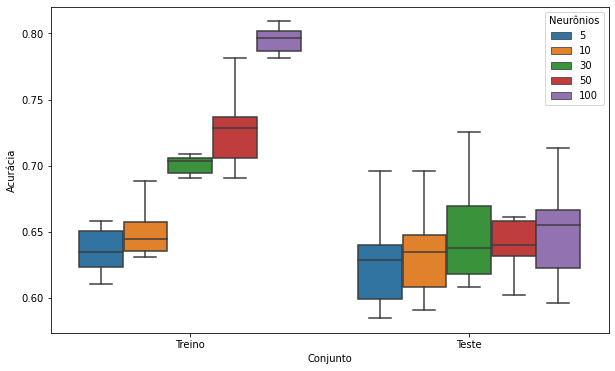

In [7]:
results_bc, datasets_bc = rbf_experiment_dataset_split(X_bc, y_bc,neurons=[5,10,30,50,100], N=10)

A partir dos resultados acima, é possível concluir que:

* A acurácia média de treinamento cresce proporcionalmente com o número de neurônios. Entretanto, se observamos a acurácia de teste, é possível notar que acima de 50 neurônios começa a ocorrer o fenômeno de over-fitting. 
* Note que para 300 neurônios temos uma acurácia de treino de praticamente 100%, porém esta atinge um valor inferior se considerarmos uma quantidade de 10 neurônios, por exemplo.
* Claramente a quantidade de neurônios é um fator a ser controlado como forma de se garantir uma boa generalização com ELMs
* Nota-se que a acurácia de teste chega ao seu máximo considerando uma quantidade de 30 a 50 neurônios.


## Parte 2: Base Statlog (Heart)

A mesma análise anterior é feita considerando a base de dados Statlog (Heart). O mesmo experimento é executado, considerando a rotina desenvolvida anteriormente. Os resultados são exibidos e analisados abaixo.

In [8]:
results_hd, datasets_hd = rbf_experiment_dataset_split(X_hd, y_hd,neurons=[5,10,30,50,100], N=10)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

 20%|██        | 1/5 [00:00<00:00,  5.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

 40%|████      | 2/5 [00:00<00:00,  3.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]Training failed at rep 0
Training failed at rep 0
Training failed at rep 0
Training failed at rep 0


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

 80%|████████  | 4/5 [00:02<00:00,  1.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]Training failed at rep 0
Training failed at rep 0
Training failed at rep 0
Training failed at rep 0
Training failed at rep 0


100%|██████████| 1/1 [00:03<00:00,  3.04s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.07

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

A partir dos resultados acima, é possível concluir que:

* Os resultados são bem similares aos encontrados para a base de dados anterior: a acurácia média de treinamento cresce proporcionalmente com o número de neurônios, porém a acurácia de teste começa a reduzir com aproximadamente 30 neurônios.
* Nota-se que a acurácia de teste chega ao seu máximo considerando uma quantidade em torno de 30 neurônios. 
* Mais uma vez, fica claro que a quantidade de neurônios é um fator importante para se obter uma boa generalização com ELMs.

## Parte 3: Comparação com o Perceptron

Um experimento similiar ao anterior é desenvolvido a seguir para avaliar o algoritmo Perceptron:

* 1) Separar o conjunto de testes entre treinamento 
* 2) Treinar o Perceptron 5 vezes
    * 2.1) Isso é necessário por causa do aprendizado com gradiente estocástico
* 3) Salvar a acurácia média de treinamento e testes

Um número máximo de 100 épocas de treinamento será utilizada. Serão considerados os mesmos conjuntos de dados utilizados em cada repetição do experimento do ELM, de forma a se ter uma comparação mais justa entre os algoritmos.


## Conclusões

Por meio dos experimentos realizados neste exercício, foi possível constatar que ELMs são capazes de obter um bom desempenho nas bases de dados avaliadas. Entretanto, é importante notar que a escolha da quantidade de neurônios é um hiper-parâmetro que deve ser bem escolhido para se conseguir obter uma boa generalização. Os resultados mostram que o aumento da quantidade de neurônios irá levar ao over-fitting deste modelo. 

Outro resultado importante foi que o Perceptron, embora seja um modelo mais simples, foi capaz de obter resultados similares ao do ELM, com a vantagem de não necessitar do ajuste de nenhum hiper-parâmetro para obter uma boa generalização. Vale a pena ressaltar que as bases de dados consideradas são linermente separáveis, de forma que não podemos extrapolar este resultado para problemas que não possuem esta característica.